In [ ]:
!pip install graphlearning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphlearning: filename=graphlearning-1.7.2-cp311-cp311-linux_x86_64.whl size=357222 sha256=2edc7fba4a825ddc6da47aecb1bf4f4bc87559182003fd16808943a7243e2e66
  Stored in directory: /root/.cache/pip/wheels/39/51/ce/aac097699ce28b546be99dc002306e1aff0c1091f463620f9b
Successfully built graphlearning


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal as mult_norm
import graphlearning.weightmatrix as wm
# import graph
# import s2algorithm
# import s2algorithm as s2algo
# from skspatial.objects import Line
import time
from scipy import sparse
# import utils
import json
import pandas as pd
import math
import os
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image, display
import shutil

In [ ]:
np.random.seed(91)

In [ ]:
# Helper functions

def EuclideanDist(point1, point2):
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**(1/2)
def NearestMean(point, means):
    return np.argmin([EuclideanDist(point, means[j]) for j in range(len(means))])
def Generate(n_per_cluster, cov, mean_arr):
    """ Create 3 gaussian clusters with given mean, covariance, and number of clusters
    """
    x1, y1 = mult_norm(mean_arr[0], cov, n_per_cluster).T
    x2, y2 = mult_norm(mean_arr[1], cov, n_per_cluster).T
    x3, y3 = mult_norm(mean_arr[2], cov, n_per_cluster).T
    x = [x1, x2, x3]
    y = [y1, y2, y3]
    data = [list(zip(x[0], y[0])), list(zip(x[1], y[1])), list(zip(x[2], y[2]))]
    data = data[0] + data[1] + data[2]
    return data

In [ ]:
# Generate Data
n_per_cluster = 500
cov = [[.1, 0], [0, .1]]
mean1 = [.6, .4]
mean2 = [.9, -1.7]
#mean3 = [-.2, .5]
mean3 = [-.6, .5]
mean_arr = [mean1, mean2, mean3]
data = Generate(n_per_cluster, cov, mean_arr)

# Relabel for discriminative clustering
labels = np.array([NearestMean(data[i], np.array(mean_arr)) for i in range(len(data))])


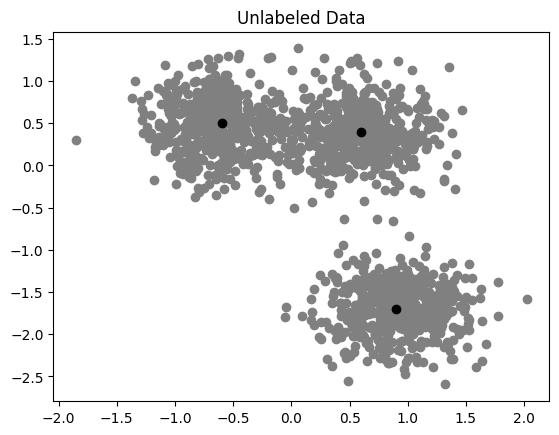

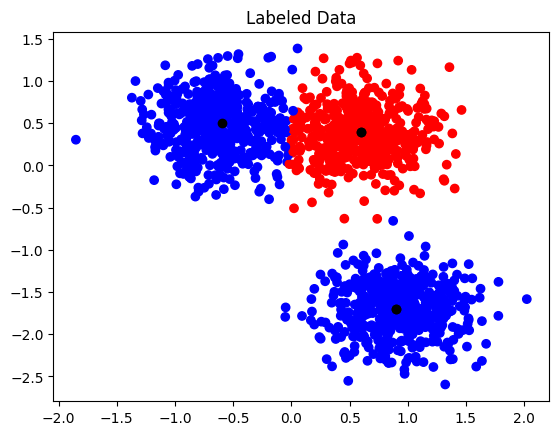

In [ ]:
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c="gray")
plt.scatter(np.array(mean_arr)[:, 0], np.array(mean_arr)[:, 1], c="k")
plt.title("Unlabeled Data")
plt.show()

# Plot labeled data
c_map = {0: 'r', 1: 'b', 2: 'b'}
color_arr = [c_map[label] for label in labels]
plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=color_arr)
plt.scatter(np.array(mean_arr)[:, 0], np.array(mean_arr)[:, 1], c='k')
plt.plot(mean1[0], mean1[1], 'ko')
plt.plot(mean2[0], mean2[1], 'ko')
plt.title("Labeled Data")
plt.show()

{0: (np.float64(0.40832770462588397), np.float64(0.06481761960092303)), 1: (np.float64(0.42578390251894416), np.float64(0.31282034601135267)), 2: (np.float64(0.9865105655445108), np.float64(0.1135422364207872)), 3: (np.float64(0.621931082382061), np.float64(1.0889514111730945)), 4: (np.float64(0.6465856975744405), np.float64(0.563571066381896)), 5: (np.float64(0.19080776880092692), np.float64(0.0664152516258858)), 6: (np.float64(0.7469727802929842), np.float64(0.474030819115515)), 7: (np.float64(1.1625268270505802), np.float64(0.6731817900139545)), 8: (np.float64(0.592075534810982), np.float64(0.35019806262406533)), 9: (np.float64(0.37926100673749996), np.float64(0.34589641577420266)), 10: (np.float64(0.389779488964034), np.float64(0.5829194696708088)), 11: (np.float64(1.2695738067197322), np.float64(0.2588377134495492)), 12: (np.float64(0.38909534943969015), np.float64(0.5520414400572504)), 13: (np.float64(1.227705824687741), np.float64(0.5239324871631524)), 14: (np.float64(1.35837831

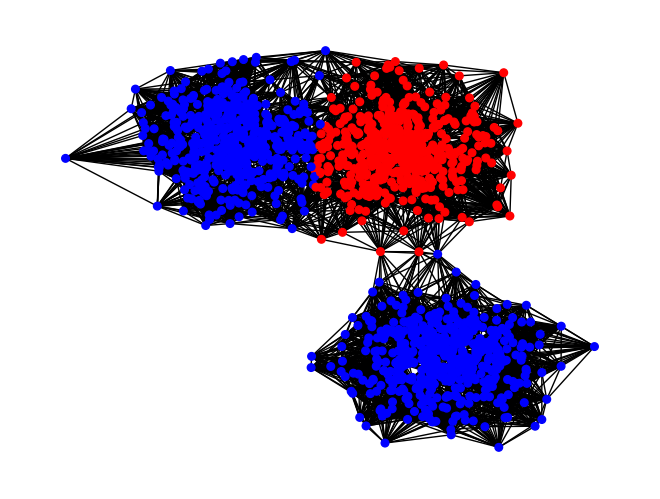

In [ ]:
# Find neighbors
A = wm.knn(np.array(data), k=30, kernel="gaussian")
# remove edges from node to itself
A.setdiag(np.zeros(len(data)))
A.eliminate_zeros()
# Create networkx graph
H = nx.from_scipy_sparse_array(A)
# Give each node position

# Value to return
pos = {i: data[i] for i in range(len(data))}
print(pos)

# Draw networkx graph
nx.draw(H, pos=pos, node_size=[30 for i in range(len(data))], node_color=color_arr)

In [ ]:
eigenvectors_list = []
H_graphs = []

def signed_laplacian_matrix(G):
    A = nx.to_numpy_array(G, weight='weight')
    D = np.diag(np.abs(A).sum(axis=1))
    L_signed = D - A
    return L_signed

L = signed_laplacian_matrix(H)
L_one_eigenvalues, L_one_eigenvectors = np.linalg.eigh(L)
idx = np.argsort(L_one_eigenvalues)
L_one_eigenvectors = L_one_eigenvectors[:, idx[0:3]]



In [ ]:
graph_frames_dir = "graph_frames"
embed_frames_dir = "embed_frames"

# Clear existing directories
for dir_path in [graph_frames_dir, embed_frames_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)  # Delete the directory and all its contents

# Recreate empty directories
os.makedirs(graph_frames_dir, exist_ok=True)
os.makedirs(embed_frames_dir, exist_ok=True)

In [ ]:
eig_3d = L_one_eigenvectors

# Soft rescale for consistency with later steps
scale = np.max(np.abs(eig_3d))
if scale > 1e-8:
    eig_3d = eig_3d / scale * 0.8

eigenvectors_list.append(eig_3d)
H_graphs.append(H.copy())

# --- Plot Step 0 Embedding ---
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

for label_class in set(labels):
    class_indices = [i for i in range(len(labels)) if labels[i] == label_class]
    points = eig_3d[class_indices]
    color = c_map.get(label_class, 'gray')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], label=f"Class {label_class}", color=color, alpha=0.4, s=10)

ax.set_title("3D Embedding at Step 0")
ax.set_xlabel("EV1")
ax.set_ylabel("EV2")
ax.set_zlabel("EV3")
ax.legend()
plt.savefig(f"{embed_frames_dir}/embed_step_000.png")
plt.close()

# --- Plot Step 0 Graph ---
plt.figure(figsize=(6, 5))
node_colors = [c_map.get(labels[n], 'gray') for n in H.nodes()]
pos_edges = [(u, v) for u, v, d in H.edges(data=True) if d['weight'] > 0]
neg_edges = [(u, v) for u, v, d in H.edges(data=True) if d['weight'] < 0]

nx.draw_networkx_nodes(H, pos=pos, node_color=node_colors, node_size=5)
nx.draw_networkx_edges(H, pos=pos, edgelist=pos_edges, edge_color='grey', width=0.3)
nx.draw_networkx_edges(H, pos=pos, edgelist=neg_edges, edge_color='green', width=0.5)

plt.title("Graph at Step 0")
plt.axis('off')
plt.savefig(f"{graph_frames_dir}/graph_step_000.png")
plt.close()

In [ ]:
def get_labels(indices):
    return [labels[idx] for idx in indices]

def get_random_points(k=3):
    indices = np.random.choice(len(data), k, replace=False)
    return indices, get_labels(indices)

def get_k_nearest_neighbors_indices(indices, k=5):
    nearest_neighbors = []
    for index in indices:
        neighbors = list(H.neighbors(index))
        if len(neighbors) <= k:
            nearest_neighbors.append(neighbors)
        else:
            neighbor_distances = [
                (EuclideanDist(data[index], data[neighbor]), neighbor)
                for neighbor in neighbors
            ]
            neighbor_distances.sort()
            k_closest = [neighbor for neighbor in neighbor_distances[:k]]
            nearest_neighbors.append(k_closest)
    return nearest_neighbors

def get_k_nearest_neighbors_labels(knn_indices_list):
    return [get_labels(knn) for knn in knn_indices_list]

def is_all_outer_ring_same_class_as_center_node(knn_labels, center_labels):
    for i in range(len(center_labels)):
        for label in knn_labels[i]:
            if label != center_labels[i]:
                return False
    return True

In [ ]:
c_map = {0: 'r', 1: 'b', 2: 'b'}
ring_weight = 0.5
spectra = []
potential_already_added_weights = [1, -1, ring_weight, -ring_weight]
for step in range(90):
    L_signed = signed_laplacian_matrix(H)
    eigenvalues, _ = np.linalg.eigh(L_signed)
    eigenvalues = np.sort(eigenvalues)
    spectra.append(eigenvalues[:10])
    indices, labels_triplet = get_random_points(k=3)
    k_nearest_neighbors_list_of_list = get_k_nearest_neighbors_indices(indices, k=30)
    k_nearest_neighbors_labels = get_k_nearest_neighbors_labels(k_nearest_neighbors_list_of_list)

    touched_nodes = set()

    # if edge weight is 1 and greater and weight to be added skip

    # Add direct edges from triplet
    for a, b in [(0, 1), (1, 2), (0, 2), (1, 0), (2, 1), (2, 0)]:
        u, v = indices[a], indices[b]
        touched_nodes.update([u, v])
        weight = 1 if c_map.get(labels_triplet[a]) == c_map.get(labels_triplet[b]) else -1
        if not H.has_edge(u, v):
            H.add_edge(u, v, weight = weight)
        else:
            H[u][v]['weight'] = weight
    # Add KNN ring edges
    for idx1 in range(len(k_nearest_neighbors_list_of_list)):
        for idx2 in range(len(k_nearest_neighbors_list_of_list)):
            if idx1 != idx2:
                list1 = k_nearest_neighbors_list_of_list[idx1]
                list2 = k_nearest_neighbors_list_of_list[idx2]
                for k in range(min(len(list1), len(list2))):
                    u, v = list1[k], list2[k]
                    touched_nodes.update([u, v])
                    label_u = k_nearest_neighbors_labels[idx1][k]
                    label_v = k_nearest_neighbors_labels[idx2][k]
                    weight = ring_weight if c_map.get(label_u) == c_map.get(label_v) else -ring_weight
                    if not H.has_edge(u, v):
                      H.add_edge(u, v, weight=weight)
                    else:
                      current_weight = H[u][v]['weight']
                      if current_weight not in potential_already_added_weights:
                        H[u][v]['weight'] = weight
                      else:
                        pass

    # Every 2 steps: update embeddings and save plots
    if (step + 1) % 5 == 0:
        # Compute signed Laplacian and eigendecomposition
        L_signed = signed_laplacian_matrix(H)
        assert np.allclose(L_signed, L_signed.T)

        eigenvalue, eigenvector = np.linalg.eigh(L_signed)
        idx = np.argsort(eigenvalue)
        eig_3d = eigenvector[:, idx[0:3]]  # EV1, EV2 and EV3

        scale = np.max(np.abs(eig_3d))
        if scale > 1e-8:
          eig_3d = eig_3d / scale * 0.8

        eigenvectors_list.append(eig_3d)
        H_graphs.append(H.copy())

        # --- Plot Graph with signed edge coloring ---
        plt.figure(figsize=(6, 5))
        node_colors = [c_map.get(labels[n], 'gray') for n in H.nodes()]

        pos_edges = [(u, v) for u, v, d in H.edges(data=True) if d['weight'] > 0]
        neg_edges = [(u, v) for u, v, d in H.edges(data=True) if d['weight'] < 0]

        nx.draw_networkx_nodes(H, pos=pos, node_color=node_colors, node_size=5)
        nx.draw_networkx_edges(H, pos=pos, edgelist=pos_edges, edge_color='grey', width=0.3)
        nx.draw_networkx_edges(H, pos=pos, edgelist=neg_edges, edge_color='green', width=0.5)

        plt.title(f"Graph at Step {step + 1}")
        plt.axis('off')
        plt.savefig(f"{graph_frames_dir}/graph_step_{step + 1:03}.png")
        plt.close()

        # --- Plot 3D Eigenvector Embedding ---
        fig = plt.figure(figsize=(8, 7))
        ax = fig.add_subplot(111, projection='3d')


        for label_class in set(labels):
            class_indices = [i for i in range(len(labels)) if labels[i] == label_class]
            points = eig_3d[class_indices]
            color = c_map.get(label_class, 'gray')
            ax.scatter(points[:, 0], points[:, 1], points[:,2], label=f"Class {label_class}", color=color, alpha=0.4, s=10)

        # Highlight touched nodes
        touched_list = list(touched_nodes)
        touched_points = eig_3d[touched_list]
        ax.scatter(
            touched_points[:, 0], touched_points[:, 1], touched_points[:,2],
            s=20, facecolors='yellow', edgecolors='black', linewidths=0.8, label="Chosen Nodes"
        )

        ax.set_title(f"3D Embedding at Step {step + 1}")
        ax.set_xlabel("EV1")
        ax.set_ylabel("EV2")
        ax.set_zlabel("EV3")
        ax.legend()
        plt.savefig(f"{embed_frames_dir}/embed_step_{step + 1:03}.png")
        plt.close()

# --- Create GIFs ---
def create_gif(frame_dir, output_path, fps=2):
    frame_files = sorted([os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith('.png')])
    images = [imageio.imread(f) for f in frame_files]
    imageio.mimsave(output_path, images, fps=fps)

create_gif(graph_frames_dir, "graph_evolution.gif")
create_gif(embed_frames_dir, "embedding_evolution.gif")

/tmp/ipython-input-12-1851284152.py:111: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f) for f in frame_files]


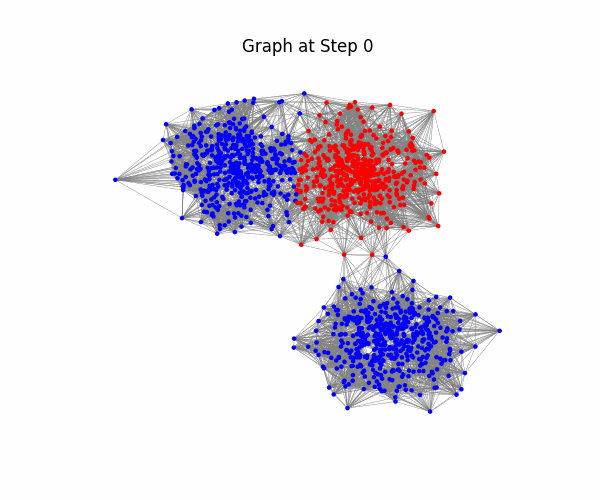

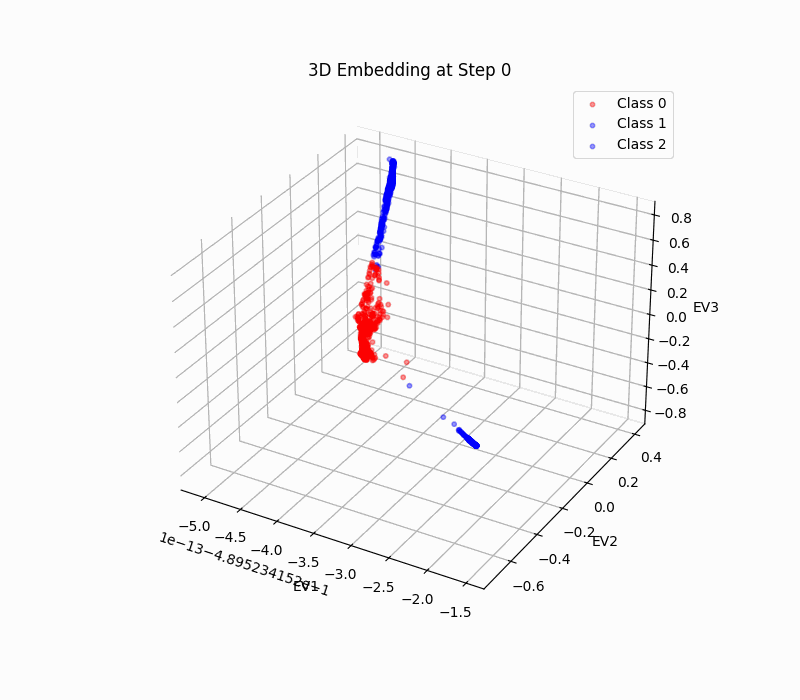

In [ ]:
display(Image(filename="graph_evolution.gif"))
display(Image(filename="embedding_evolution.gif"))

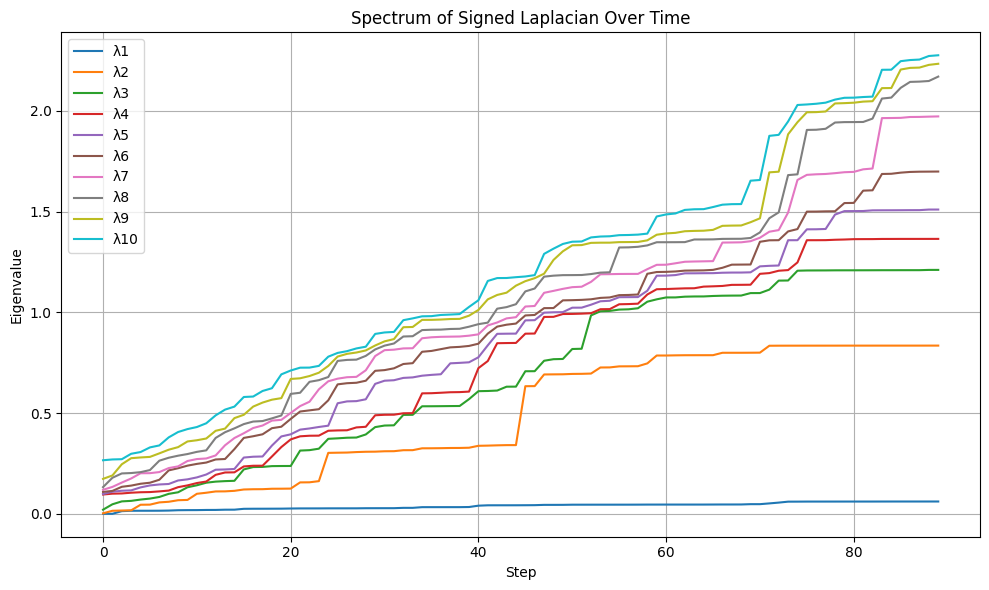

In [ ]:
spectra = np.array(spectra)  # shape: (num_steps, k)

plt.figure(figsize=(10, 6))
for i in range(spectra.shape[1]):
    plt.plot(spectra[:, i], label=f"λ{i+1}")

plt.title("Spectrum of Signed Laplacian Over Time")
plt.xlabel("Step")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(len(eigenvectors_list))

19


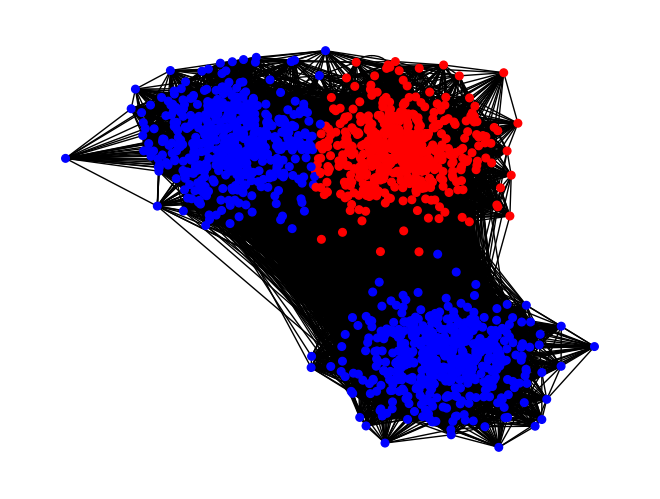

In [ ]:
nx.draw(H_graphs[len(H_graphs)-1], pos=pos, node_size=[30 for i in range(len(data))], node_color=color_arr)

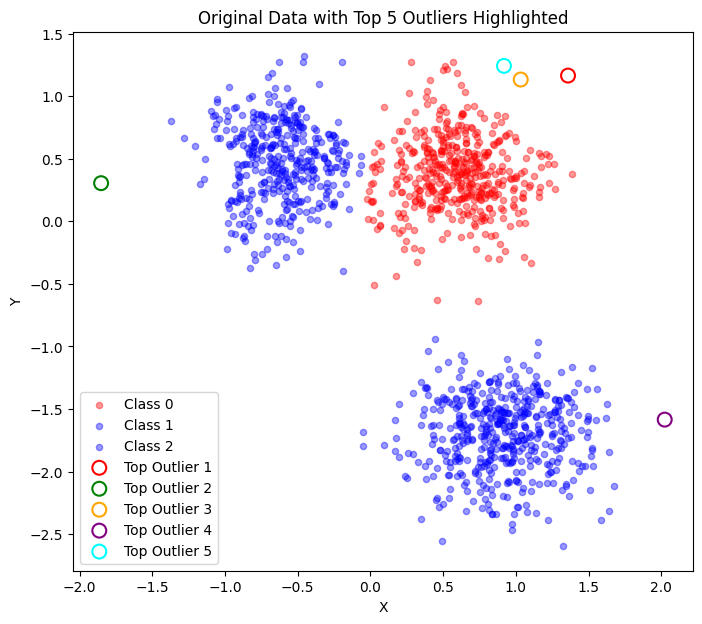

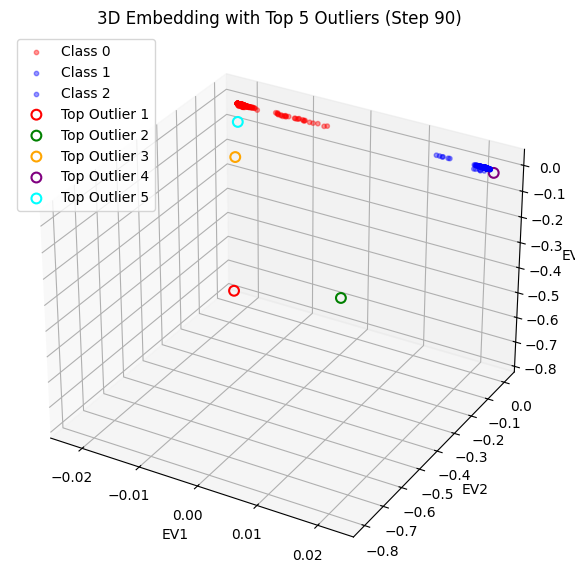

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Define last_embedding
last_embedding = eigenvectors_list[-1]

# --- Find outliers using LOF ---
lof = LocalOutlierFactor(n_neighbors=30, contamination='auto')
outlier_scores = lof.fit_predict(last_embedding)
outlier_indices = np.where(outlier_scores == -1)[0]
non_outlier_indices = np.where(outlier_scores == 1)[0]

# --- Get top 5 outliers ---
outlier_scores_values = lof.negative_outlier_factor_
top_outlier_indices = np.argsort(outlier_scores_values)[:5]


# --- Plot Original Data with Top Outliers ---
plt.figure(figsize=(8, 7))

# Plot non-outliers
non_outlier_data = np.array(data)[non_outlier_indices]
non_outlier_labels = np.array(labels)[non_outlier_indices]
for label_class in set(labels):
    class_indices = [i for i, label in enumerate(non_outlier_labels) if label == label_class]
    points = non_outlier_data[class_indices]
    color = c_map.get(label_class, 'gray')
    plt.scatter(points[:, 0], points[:, 1], label=f"Class {label_class}", color=color, alpha=0.4, s=20)

# Highlight top outliers with different colors
outlier_colors = ['red', 'green', 'orange', 'purple', 'cyan']
for i, outlier_index in enumerate(top_outlier_indices):
    outlier_data = np.array(data)[outlier_index]
    plt.scatter(
        outlier_data[0], outlier_data[1],
        s=100, facecolors='none', edgecolors=outlier_colors[i], linewidths=1.5, label=f"Top Outlier {i+1}"
    )


plt.title("Original Data with Top 5 Outliers Highlighted")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


# --- Plot 3D Eigenvector Embedding with Top Outliers (Step 90) ---
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot non-outliers
for label_class in set(labels):
    class_indices = [i for i in non_outlier_indices if labels[i] == label_class]
    points = last_embedding[class_indices]
    color = c_map.get(label_class, 'gray')
    ax.scatter(points[:, 0], points[:, 1], points[:,2], label=f"Class {label_class}", color=color, alpha=0.4, s=10)

# Highlight top outliers with different colors
for i, outlier_index in enumerate(top_outlier_indices):
    outlier_point = last_embedding[outlier_index]
    ax.scatter(
        outlier_point[0], outlier_point[1], outlier_point[2],
        s=50, facecolors='none', edgecolors=outlier_colors[i], linewidths=1.5, label=f"Top Outlier {i+1}"
    )

ax.set_title(f"3D Embedding with Top 5 Outliers (Step 90)")
ax.set_xlabel("EV1")
ax.set_ylabel("EV2")
ax.set_zlabel("EV3")
ax.legend()
plt.show()

/tmp/ipython-input-12-1851284152.py:111: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f) for f in frame_files]


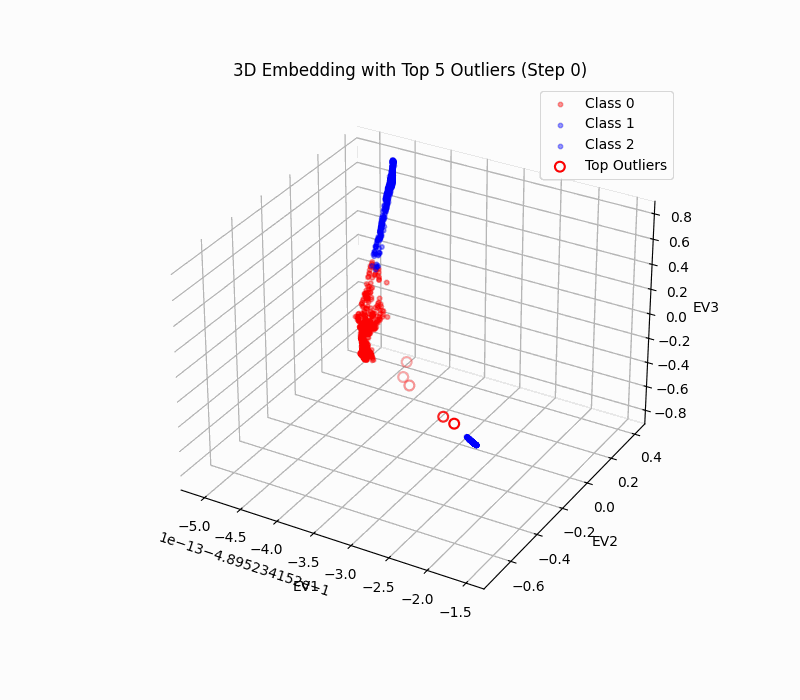

In [ ]:
# --- Create a new directory for the outlier GIF frames ---
outlier_embed_frames_dir = "outlier_embed_frames"
if os.path.exists(outlier_embed_frames_dir):
    shutil.rmtree(outlier_embed_frames_dir)
os.makedirs(outlier_embed_frames_dir, exist_ok=True)


# --- Generate frames for the outlier GIF ---
for i, (H_graph, embedding) in enumerate(zip(H_graphs, eigenvectors_list)):
    step = i * 5

    # --- Find top 5 outliers using LOF for the current embedding ---
    lof = LocalOutlierFactor(n_neighbors=30, contamination='auto')
    outlier_scores = lof.fit_predict(embedding)
    outlier_indices = np.where(outlier_scores == -1)[0]
    non_outlier_indices = np.where(outlier_scores == 1)[0]
    outlier_scores_values = lof.negative_outlier_factor_
    top_outlier_indices = np.argsort(outlier_scores_values)[:5]

    # --- Plot 3D Eigenvector Embedding with Top Outliers ---
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot non-outliers
    for label_class in set(labels):
        class_indices = [j for j in non_outlier_indices if labels[j] == label_class]
        points = embedding[class_indices]
        color = c_map.get(label_class, 'gray')
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], label=f"Class {label_class}", color=color, alpha=0.4, s=10)

    # Highlight top outliers
    top_outlier_points = embedding[top_outlier_indices]
    ax.scatter(
        top_outlier_points[:, 0], top_outlier_points[:, 1], top_outlier_points[:, 2],
        s=50, facecolors='none', edgecolors='red', linewidths=1.5, label="Top Outliers"
    )

    ax.set_title(f"3D Embedding with Top 5 Outliers (Step {step})")
    ax.set_xlabel("EV1")
    ax.set_ylabel("EV2")
    ax.set_zlabel("EV3")
    ax.legend()
    plt.savefig(f"{outlier_embed_frames_dir}/embed_step_{step:03}.png")
    plt.close()


# --- Create the outlier GIF ---
create_gif(outlier_embed_frames_dir, "outlier_embedding_evolution.gif")

# --- Display the new GIF ---
display(Image(filename="outlier_embedding_evolution.gif"))